In [ ]:
# Logistic Regression using Bag of Words

In [7]:
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [4]:
base_dir = os.getcwd()
datafile = os.path.join(base_dir, "data", "data_cleaned.csv")
df = pd.read_csv(datafile, index_col=None)

In [5]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=33)
x_train = train_df['tokens']
x_test = test_df['tokens']
y_train = train_df['label']
y_test = test_df['label']

In [4]:
vectorizer_unigrams = CountVectorizer(ngram_range=(1,1), lowercase=True, stop_words='english', max_features = 100000)
x_train_bow_unigrams = vectorizer_unigrams.fit_transform(x_train)
x_test_bow_unigrams  = vectorizer_unigrams.transform(x_test)

vectorizer_unigrams_bigrams = CountVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english', max_features = 1000000)
x_train_bow_unigrams_bigrams = vectorizer_unigrams_bigrams.fit_transform(x_train)
x_test_bow_unigrams_bigrams  = vectorizer_unigrams_bigrams.transform(x_test)

vectorizer_unigrams_bigrams_trigrams = CountVectorizer(ngram_range=(1,3), lowercase=True, stop_words='english', max_features = 1150000)
x_train_bow_unigrams_bigrams_trigrams = vectorizer_unigrams_bigrams_trigrams.fit_transform(x_train)
x_test_bow_unigrams_bigrams_trigrams  = vectorizer_unigrams_bigrams_trigrams.transform(x_test)

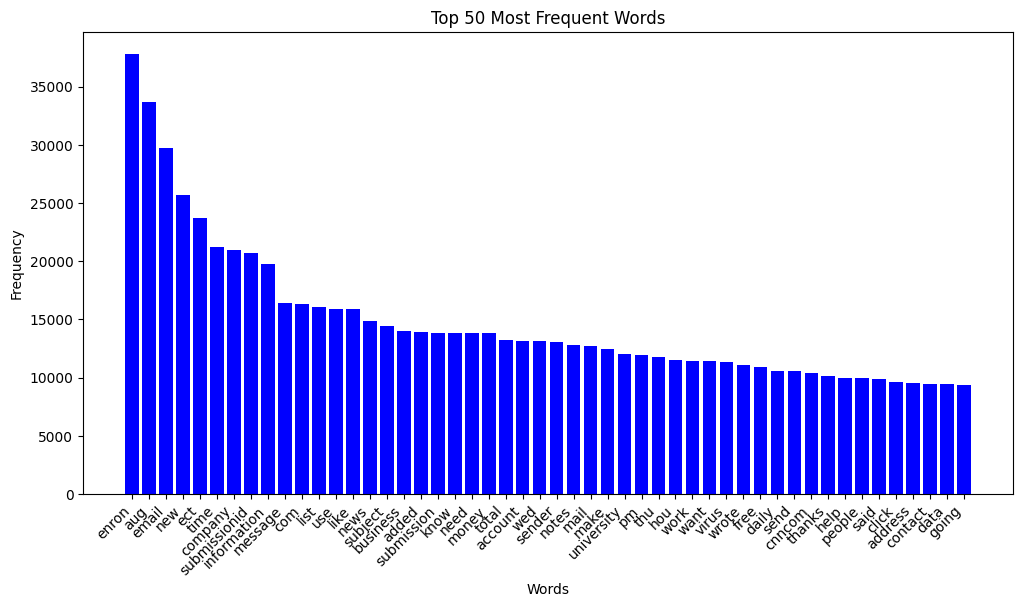

In [5]:
feature_names = vectorizer_unigrams.get_feature_names_out()
word_frequencies = np.array(x_train_bow_unigrams.sum(axis=0)).flatten()
word_freq_df = pd.DataFrame({'word': feature_names, 'frequency': word_frequencies})
top_words = word_freq_df.nlargest(50, 'frequency')

# Plot for top 50 most frequent words across training data set
plt.figure(figsize=(12, 6))
plt.bar(top_words['word'], top_words['frequency'], color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 50 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

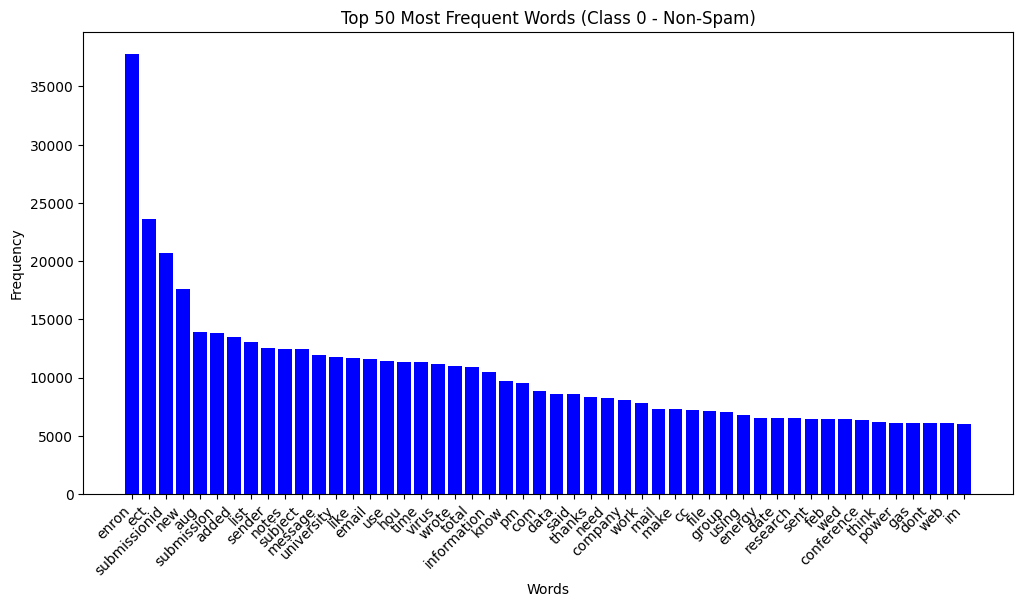

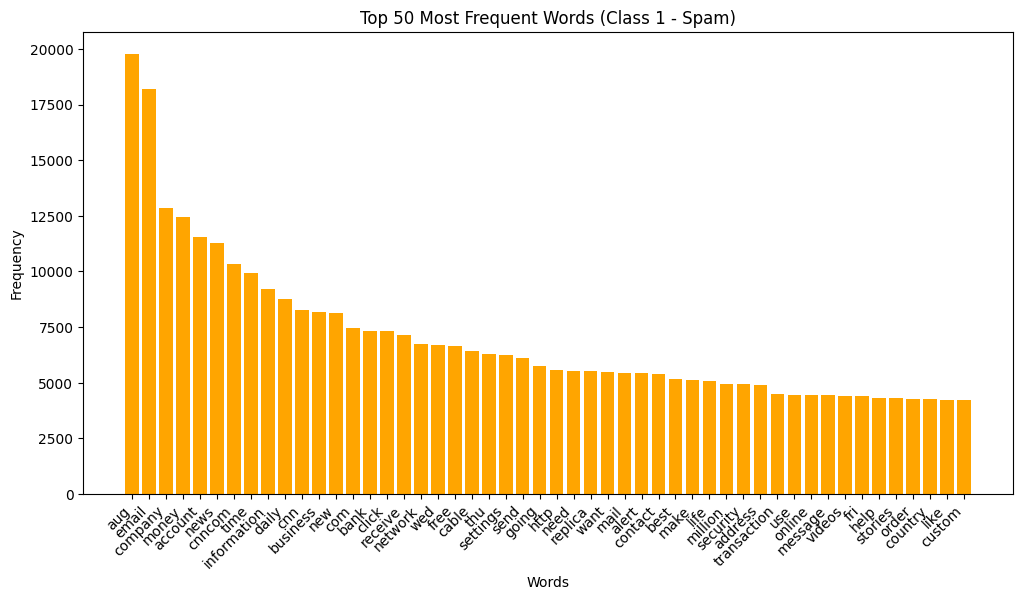

In [6]:
y_train_array = np.array(y_train)

x_train_class_0 = x_train_bow_unigrams[y_train_array == 0]
x_train_class_1 = x_train_bow_unigrams[y_train_array == 1]

# Calculate word frequencies for each class
word_frequencies_class_0 = np.array(x_train_class_0.sum(axis=0)).flatten()
word_frequencies_class_1 = np.array(x_train_class_1.sum(axis=0)).flatten()

word_freq_df_class_0 = pd.DataFrame({'word': feature_names, 'frequency': word_frequencies_class_0})
word_freq_df_class_1 = pd.DataFrame({'word': feature_names, 'frequency': word_frequencies_class_1})

# Get the top 50 words for each class
top_words_class_0 = word_freq_df_class_0.nlargest(50, 'frequency')
top_words_class_1 = word_freq_df_class_1.nlargest(50, 'frequency')

# Plot for Class 0
plt.figure(figsize=(12, 6))
plt.bar(top_words_class_0['word'], top_words_class_0['frequency'], color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 50 Most Frequent Words (Class 0 - Non-Spam)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

# Plot for Class 1
plt.figure(figsize=(12, 6))
plt.bar(top_words_class_1['word'], top_words_class_1['frequency'], color='orange')
plt.xticks(rotation=45, ha='right')
plt.title('Top 50 Most Frequent Words (Class 1 - Spam)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [10]:
# l1 penalty has been tried, l2 is always better
param_grid = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['saga'],
    'max_iter': [2500]  # increase if the solver needs more iterations
}

logreg = LogisticRegression(random_state=33)

# n_jobs=-1 uses all CPU cores. cv=5 for a 5-fold cross-validation.
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='accuracy',       # or 'f1', 'precision', 'recall', etc.
    cv=5,
    n_jobs=11,
    verbose=1
)

In [8]:
log_bow = grid_search.fit(x_train_bow_unigrams, y_train)
print("Best Score from CV:", grid_search.best_score_)
print("Best Params:", grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score from CV: 0.9570315206096295
Best Params: {'C': 0.1, 'max_iter': 2500, 'penalty': 'l2', 'solver': 'saga'}


D:\ML\AML\.venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# These are 2 other grid searches we tried using unigrams + bigrams, and unigrams + bigrams + trigrams

# grid_search.fit(x_train_bow_unigrams_bigrams, y_train)
# print("Best Score from CV:", grid_search.best_score_)
# print("Best Params:", grid_search.best_params_)

# grid_search.fit(x_train_bow_unigrams_bigrams_trigrams, y_train)
# print("Best Score from CV:", grid_search.best_score_)
# print("Best Params:", grid_search.best_params_)

In [9]:
best_logreg = log_bow.best_estimator_

# Predict classes
y_pred_bow = best_logreg.predict(x_test_bow_unigrams)

# Predict probabilities
y_pred_proba_bow = best_logreg.predict_proba(x_test_bow_unigrams)

In [10]:
accuracy = accuracy_score(y_test, y_pred_bow)
print("Test Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_bow))

Test Accuracy: 0.9576901317384627

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     11951
           1       0.95      0.97      0.96     12795

    accuracy                           0.96     24746
   macro avg       0.96      0.96      0.96     24746
weighted avg       0.96      0.96      0.96     24746



In [11]:
coefficients = best_logreg.coef_[0]
feature_names = vectorizer_unigrams.get_feature_names_out()

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

top_positive_features = coef_df.nlargest(25, 'coefficient')  # Top 25 positive
top_negative_features = coef_df.nsmallest(25, 'coefficient') # Top 25 negative

# Print the results
print("Top 25 Positive Features:")
print(top_positive_features)

print("\nTop 25 Negative Features:")
print(top_negative_features)

Top 25 Positive Features:
            feature  coefficient
8613            aug     0.507175
58581         money     0.387515
75878       replica     0.365388
53239          life     0.362198
41726          http     0.336573
3182        account     0.312748
96391       watches     0.304450
17412         click     0.274979
54332          love     0.258934
11191          best     0.237290
18698       company     0.226375
39652        health     0.216953
82729          site     0.213442
56912           men     0.209362
23304          dear     0.201923
90193           thu     0.193210
96666           wed     0.191785
64234        online     0.181381
95266        viagra     0.177614
73084       quality     0.176000
17795        cnncom     0.173346
38213    guaranteed     0.169868
9834           bank     0.163994
77573         rolex     0.161758
71404  professional     0.160894

Top 25 Negative Features:
                                               feature  coefficient
98068                

In [6]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), lowercase=True, stop_words='english', max_features=100000)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

In [8]:
with open(os.path.join('models', 'tfidf_vectorizer.joblib'), 'wb') as file:
    joblib.dump(tfidf_vectorizer, file)

In [11]:
log_tfidf = grid_search.fit(x_train_tfidf, y_train)
print("Best Score from CV:", grid_search.best_score_)
print("Best Params:", grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score from CV: 0.990128160720471
Best Params: {'C': 100, 'max_iter': 2500, 'penalty': 'l2', 'solver': 'saga'}


In [12]:
best_logreg_tfidf = log_tfidf.best_estimator_

# Predict classes
y_pred_tfidf = best_logreg_tfidf.predict(x_test_tfidf)

# Predict probabilities
y_pred_proba_tfidf = best_logreg_tfidf.predict_proba(x_test_tfidf)

In [13]:
with open(os.path.join('models', 'LR_TFIDF.joblib'), 'wb') as file:
    joblib.dump(best_logreg_tfidf, file)

In [15]:
accuracy = accuracy_score(y_test, y_pred_tfidf)
print("Test Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf))

Test Accuracy: 0.9896548937201972

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11951
           1       0.99      0.99      0.99     12795

    accuracy                           0.99     24746
   macro avg       0.99      0.99      0.99     24746
weighted avg       0.99      0.99      0.99     24746



In [16]:
coefficients = best_logreg_tfidf.coef_[0]
feature_names = tfidf_vectorizer.get_feature_names_out()

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

top_positive_features = coef_df.nlargest(25, 'coefficient')  # Top 25 positive
top_negative_features = coef_df.nsmallest(25, 'coefficient') # Top 25 negative

# Print the results
print("Top 25 Positive Features:")
print(top_positive_features)

print("\nTop 25 Negative Features:")
print(top_negative_features)

Top 25 Positive Features:
             feature  coefficient
49867  josemonkeyorg    17.513649
41726           http    12.174009
50973         kindly    11.815111
75667         remove    11.121579
53239           life    10.937468
54332           love    10.408301
90193            thu    10.326996
48279     investment    10.192754
58581          money    10.065715
8613             aug     9.836421
17412          click     9.750935
73084        quality     9.592773
56716           meds     9.548923
96666            wed     8.457024
61080            net     8.326277
58242         mobile     8.315309
23304           dear     8.297327
58639      monkeyorg     8.243216
22129         custom     8.227656
37491             gr     8.106917
3182         account     7.986031
9834            bank     7.968289
95266         viagra     7.884516
66899        payment     7.844026
17421     clickfraud     7.841096

Top 25 Negative Features:
                                               feature  coeffic

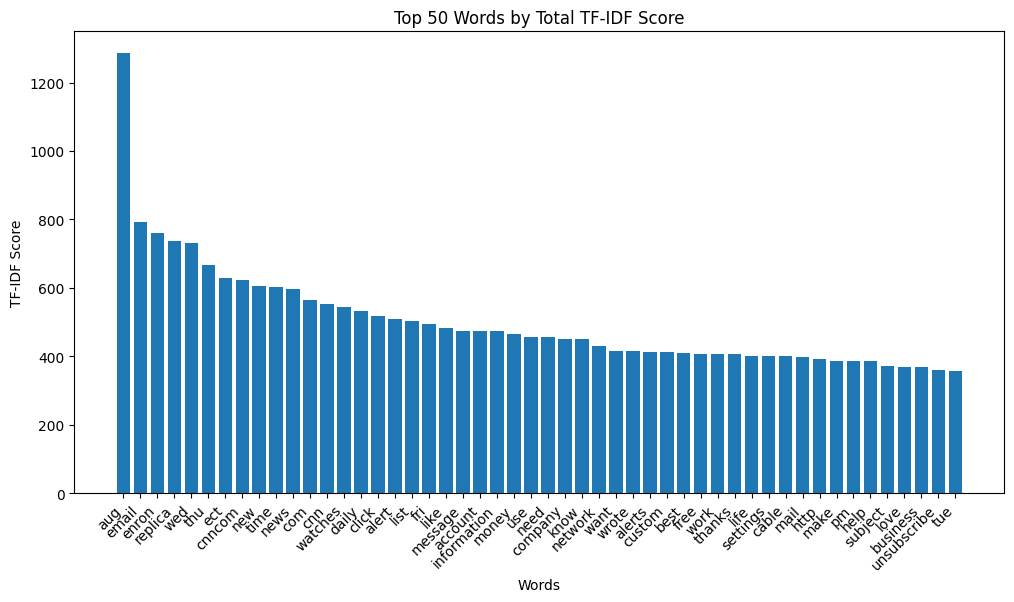

In [17]:
tfidf_scores = np.array(x_train_tfidf.sum(axis=0)).flatten()

tfidf_df = pd.DataFrame({'word': tfidf_vectorizer.get_feature_names_out(), 'tfidf_score': tfidf_scores})
top_tfidf_words = tfidf_df.nlargest(50, 'tfidf_score')

# Plot the top 50 words
plt.figure(figsize=(12, 6))
plt.bar(top_tfidf_words['word'], top_tfidf_words['tfidf_score'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 50 Words by Total TF-IDF Score')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.show()

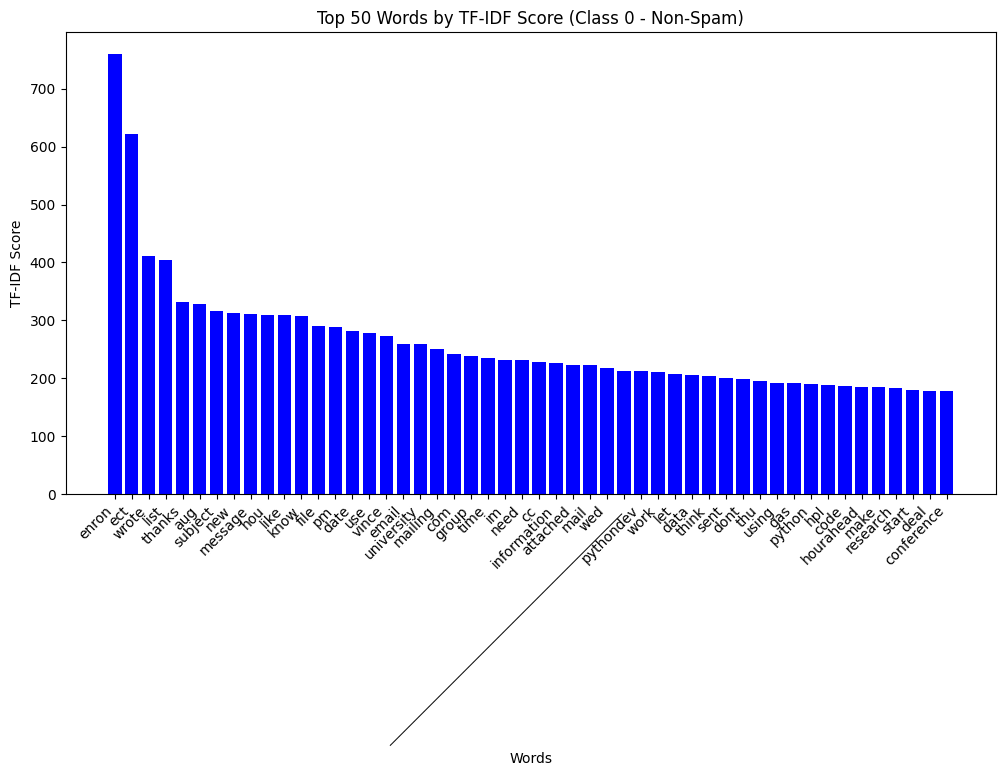

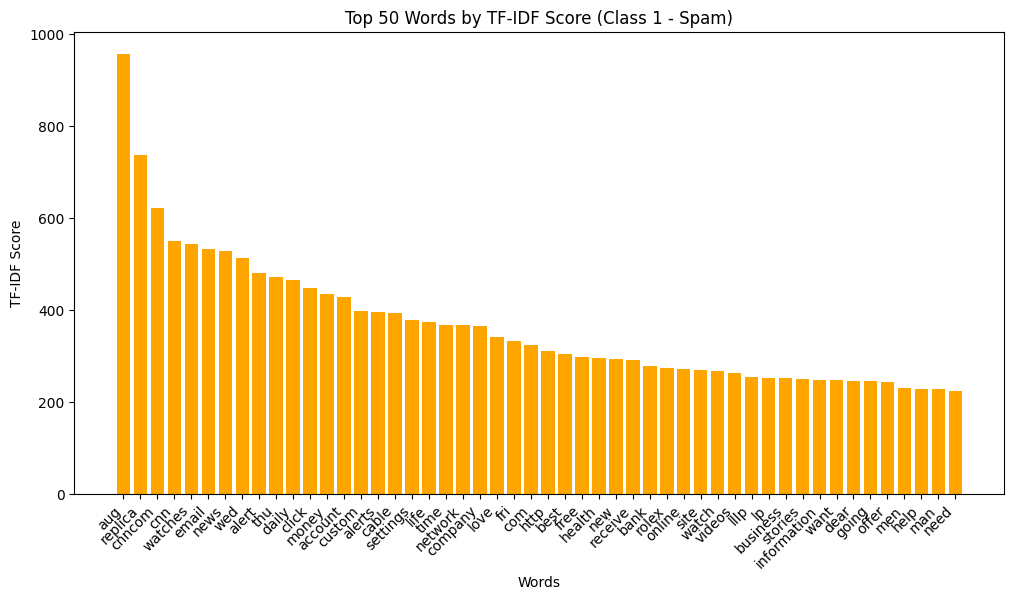

In [18]:
y_train_array = np.array(y_train)

# Get TF-IDF matrices for each class
x_train_tfidf_class_0 = x_train_tfidf[y_train_array == 0]
x_train_tfidf_class_1 = x_train_tfidf[y_train_array == 1]

# Calculate total TF-IDF scores for each class
tfidf_scores_class_0 = np.array(x_train_tfidf_class_0.sum(axis=0)).flatten()
tfidf_scores_class_1 = np.array(x_train_tfidf_class_1.sum(axis=0)).flatten()

feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df_class_0 = pd.DataFrame({'word': feature_names, 'tfidf_score': tfidf_scores_class_0})
tfidf_df_class_1 = pd.DataFrame({'word': feature_names, 'tfidf_score': tfidf_scores_class_1})

# Get the top 50 words for each class
top_tfidf_words_class_0 = tfidf_df_class_0.nlargest(50, 'tfidf_score')
top_tfidf_words_class_1 = tfidf_df_class_1.nlargest(50, 'tfidf_score')

# Plot for Class 0 (Non-Spam)
plt.figure(figsize=(12, 6))
plt.bar(top_tfidf_words_class_0['word'], top_tfidf_words_class_0['tfidf_score'], color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 50 Words by TF-IDF Score (Class 0 - Non-Spam)')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.show()

# Plot for Class 1 (Spam)
plt.figure(figsize=(12, 6))
plt.bar(top_tfidf_words_class_1['word'], top_tfidf_words_class_1['tfidf_score'], color='orange')
plt.xticks(rotation=45, ha='right')
plt.title('Top 50 Words by TF-IDF Score (Class 1 - Spam)')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.show()